In [ ]:
import os 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install -U --no-cache-dir gdown --pre
# weather-dataset.zip
!gdown --id 1DYI92Au6-HeaM2ANLDm1cfmVoiFUOn4F
!unzip weather-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-dataset/da

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# 1. DATA PRE-PROCESSING

In [ ]:
WEATHER_DATA_PATH = './weather-dataset/dataset/'

labels = [label for label in os.listdir(WEATHER_DATA_PATH)
                for path in os.listdir(os.path.join(WEATHER_DATA_PATH, label))]
path_images = [os.path.join(WEATHER_DATA_PATH, label, path) for label in os.listdir(WEATHER_DATA_PATH) 
                                                            for path in os.listdir(os.path.join(WEATHER_DATA_PATH, label))]

file_path = pd.Series(path_images, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')

data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,File_Path,Labels
0,./weather-dataset/dataset/snow/1306.jpg,snow
1,./weather-dataset/dataset/glaze/6478.jpg,glaze
2,./weather-dataset/dataset/hail/0130.png,hail
3,./weather-dataset/dataset/fogsmog/4509.jpg,fogsmog
4,./weather-dataset/dataset/fogsmog/4373.jpg,fogsmog
5,./weather-dataset/dataset/sandstorm/3233.jpg,sandstorm
6,./weather-dataset/dataset/rainbow/0595.jpg,rainbow
7,./weather-dataset/dataset/dew/2762.jpg,dew
8,./weather-dataset/dataset/sandstorm/3272.jpg,sandstorm
9,./weather-dataset/dataset/hail/0300.jpg,hail


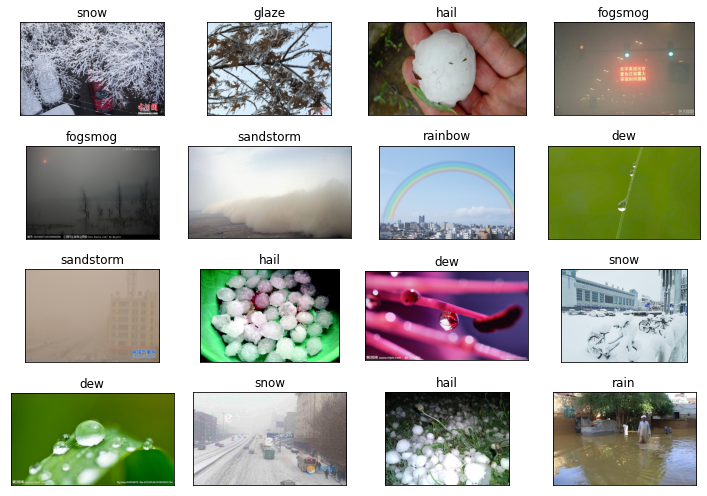

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7), 
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(data.File_Path[i]))
  ax.set_title(data.Labels[i])

plt.tight_layout()
plt.show()

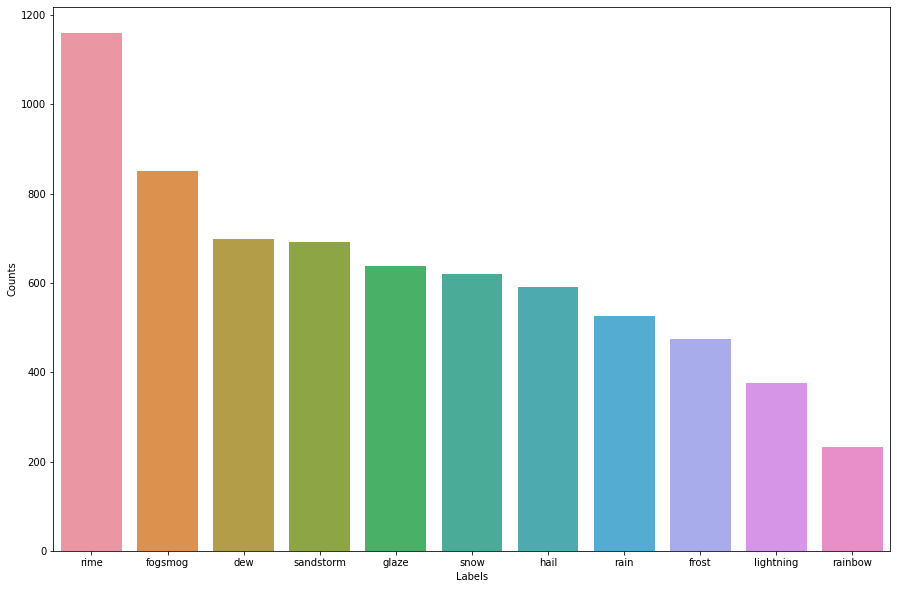

In [ ]:
counts = data.Labels.value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
          directory=WEATHER_DATA_PATH,
          validation_split=0.2, 
          subset='training', 
          seed=123, 
          image_size=(IMG_HEIGHT, IMG_WIDTH), 
          batch_size=BATCH_SIZE
)

val_ds = keras.utils.image_dataset_from_directory(
          directory=WEATHER_DATA_PATH,
          validation_split=0.2, 
          subset='validation', 
          seed=123, 
          image_size=(IMG_HEIGHT, IMG_WIDTH), 
          batch_size=BATCH_SIZE
)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

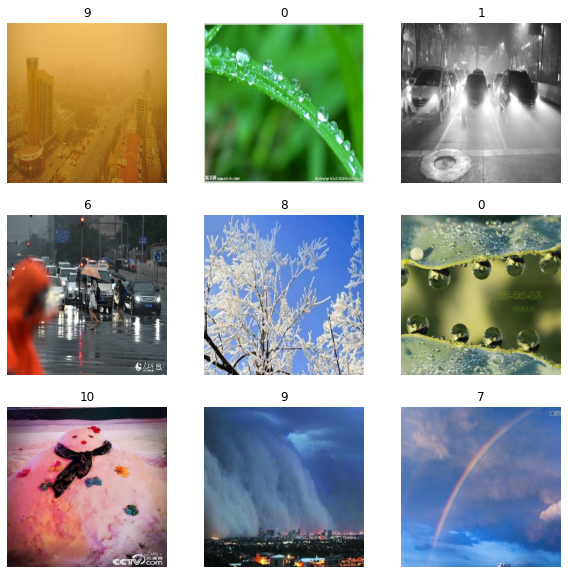

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(0, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(int(labels[i]))
    plt.axis('off')

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.Rescaling(scale=1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

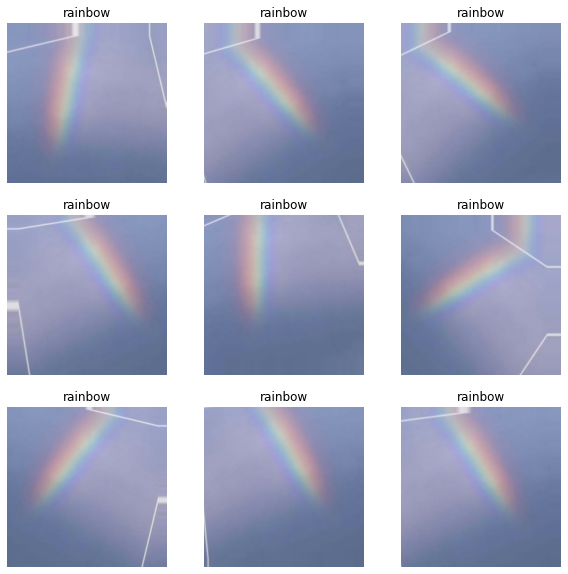

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(),axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

# 2. MODEL CONSTRUCTION



## 2.1. ResNet34 (No Skip Connection)

In [ ]:
class ResNet34NoSkip():
  def __init__(self):
    pass

  def identity_block(self, inputs, filters):
    x = layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)

    return x

  def projection_block(self, inputs, filters, strides=2):
    x = layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', strides=strides, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters=filters, kernel_size=(3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)

    return x

  def build_model(self, classes, input_shape=(224,224,3)):

    # Input: block 1
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', use_bias=False)(inputs)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=2)(x)

    # Block 2
    x = self.identity_block(x, 64)
    x = self.identity_block(x, 64)
    x = self.identity_block(x, 64)

    # Block 3
    x = self.projection_block(x, 128)
    x = self.identity_block(x, 128)
    x = self.identity_block(x, 128)
    x = self.identity_block(x, 128)

    # Block 4
    x = self.projection_block(x, 256)
    x = self.identity_block(x, 256)
    x = self.identity_block(x, 256)
    x = self.identity_block(x, 256)
    x = self.identity_block(x, 256)
    x = self.identity_block(x, 256)

    # Output: block 5
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
build_resnet34 = ResNet34NoSkip()
resnet34_model_noskip = build_resnet34.build_model(classes=11)
resnet34_model_noskip.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 55, 55, 64)        36864     
                                                                 
 batch_normalization_26 (Bat  (None, 55, 55, 64)       256       
 chNormalization)                                                
                                                                 
 activation_26 (Activation)  (None, 55, 55, 64)        0   

In [ ]:
num_epochs=50

resnet34_model_noskip.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
                              loss=keras.losses.SparseCategoricalCrossentropy(), 
                              metrics=['accuracy'])

history = resnet34_model_noskip.fit(train_ds, 
                                    epochs=num_epochs, 
                                    validation_data=val_ds,
                                    verbose=2)

Epoch 1/50
172/172 - 41s - loss: 2.1776 - accuracy: 0.2215 - val_loss: 4.1761 - val_accuracy: 0.1115 - 41s/epoch - 236ms/step
Epoch 2/50
172/172 - 28s - loss: 1.5995 - accuracy: 0.4561 - val_loss: 2.7439 - val_accuracy: 0.2850 - 28s/epoch - 165ms/step
Epoch 3/50
172/172 - 28s - loss: 1.3691 - accuracy: 0.5328 - val_loss: 1.4577 - val_accuracy: 0.4956 - 28s/epoch - 163ms/step
Epoch 4/50
172/172 - 29s - loss: 1.2514 - accuracy: 0.5701 - val_loss: 1.3378 - val_accuracy: 0.5408 - 29s/epoch - 166ms/step
Epoch 5/50
172/172 - 29s - loss: 1.1772 - accuracy: 0.5984 - val_loss: 1.2246 - val_accuracy: 0.5860 - 29s/epoch - 171ms/step
Epoch 6/50
172/172 - 28s - loss: 1.1148 - accuracy: 0.6144 - val_loss: 1.3225 - val_accuracy: 0.5401 - 28s/epoch - 163ms/step
Epoch 7/50
172/172 - 28s - loss: 1.0506 - accuracy: 0.6375 - val_loss: 1.1149 - val_accuracy: 0.6137 - 28s/epoch - 163ms/step
Epoch 8/50
172/172 - 28s - loss: 1.0245 - accuracy: 0.6497 - val_loss: 1.1407 - val_accuracy: 0.6181 - 28s/epoch - 163

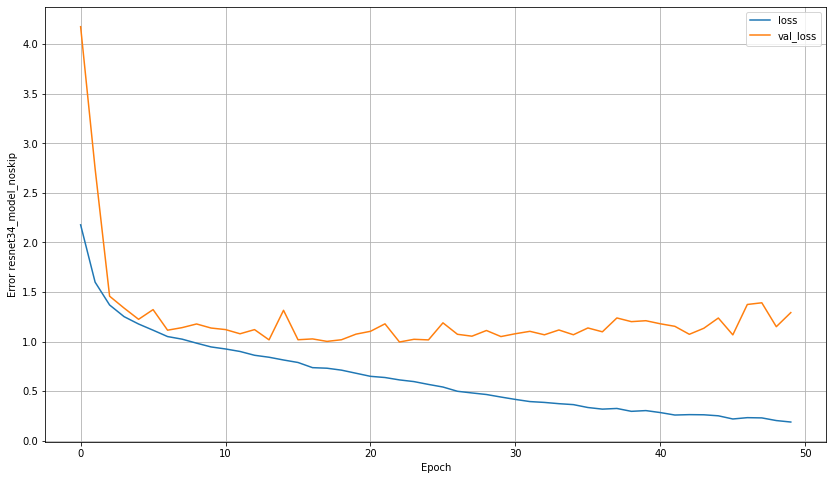

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error resnet34_model_noskip')
plt.legend()
plt.grid(True)

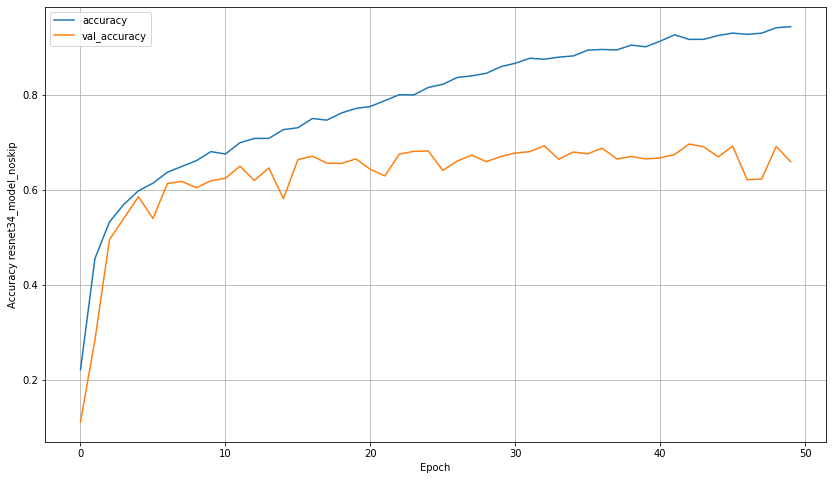

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy resnet34_model_noskip')
plt.legend()
plt.grid(True)

## 2.2.1. ResNet34 (Skip Connection - CONCATENATE)

In [ ]:
class ResNet34Skip():
  def __init__(self):
    pass

  def identity_block(self, inputs, filters):
      x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(inputs)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('relu')(x)
      
      x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
      x = layers.BatchNormalization()(x)
      
      skip_connection = layers.add([inputs, x])     
      x = layers.Activation('relu')(skip_connection)
      
      return x
  
  
  def projection_block(self, inputs, filters, strides=2):
      x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=strides, use_bias=False)(inputs)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('relu')(x)
      
      x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
      x = layers.BatchNormalization()(x)
      
      shortcut = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same', 
                                strides=strides, use_bias=False)(inputs)
      shortcut = layers.BatchNormalization()(shortcut)
      
      skip_connection = layers.Concatenate([shortcut, x])        
      x = layers.Activation('relu')(skip_connection)
      
      return x

  def build_model(self, classes, input_shape=(224,224,3)):

      # Input: block 1
      inputs = layers.Input(shape=input_shape)
      x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', use_bias=False)(inputs)
      x = layers.MaxPool2D(pool_size=(3, 3), strides=2)(x)

      # Block 2
      x = self.identity_block(x, 64)
      x = self.identity_block(x, 64)
      x = self.identity_block(x, 64)

      # Block 3
      x = self.projection_block(x, 128)
      x = self.identity_block(x, 128)
      x = self.identity_block(x, 128)
      x = self.identity_block(x, 128)

      # Block 4
      x = self.projection_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)

      # Output: block 5
      x = layers.GlobalAveragePooling2D()(x)
      outputs = layers.Dense(classes, activation='softmax')(x)

      model = Model(inputs=inputs, outputs=outputs)

      return model

In [ ]:
# concatenate
build_resnet34 = ResNet34Skip()
resnet34_model_skip = build_resnet34.build_model(classes=11)
resnet34_model_skip.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 112, 112, 64  9408        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 55, 55, 64)  0           ['conv2d_54[0][0]']              
                                                                                            

In [ ]:
num_epochs=50

resnet34_model_skip.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
                              loss=keras.losses.SparseCategoricalCrossentropy(), 
                              metrics=['accuracy'])

resnet34_skip_history = resnet34_model_skip.fit(train_ds, 
                                    epochs=num_epochs, 
                                    validation_data=val_ds,
                                    verbose=2)

Epoch 1/50
172/172 - 33s - loss: 1.8145 - accuracy: 0.4821 - val_loss: 1.7225 - val_accuracy: 0.4789 - 33s/epoch - 190ms/step
Epoch 2/50
172/172 - 29s - loss: 1.0857 - accuracy: 0.6452 - val_loss: 1.1994 - val_accuracy: 0.6356 - 29s/epoch - 170ms/step
Epoch 3/50
172/172 - 29s - loss: 0.9390 - accuracy: 0.6929 - val_loss: 1.0326 - val_accuracy: 0.6684 - 29s/epoch - 170ms/step
Epoch 4/50
172/172 - 29s - loss: 0.8364 - accuracy: 0.7244 - val_loss: 1.0400 - val_accuracy: 0.6815 - 29s/epoch - 170ms/step
Epoch 5/50
172/172 - 29s - loss: 0.7718 - accuracy: 0.7499 - val_loss: 0.9266 - val_accuracy: 0.7150 - 29s/epoch - 171ms/step
Epoch 6/50
172/172 - 29s - loss: 0.6873 - accuracy: 0.7707 - val_loss: 1.0015 - val_accuracy: 0.6793 - 29s/epoch - 169ms/step
Epoch 7/50
172/172 - 29s - loss: 0.6308 - accuracy: 0.7893 - val_loss: 0.9711 - val_accuracy: 0.6815 - 29s/epoch - 169ms/step
Epoch 8/50
172/172 - 29s - loss: 0.5628 - accuracy: 0.8104 - val_loss: 0.8776 - val_accuracy: 0.7223 - 29s/epoch - 171

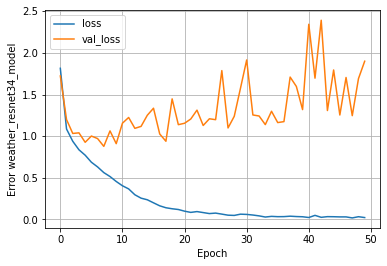

In [ ]:
plt.plot(resnet34_skip_history.history['loss'], label='loss')
plt.plot(resnet34_skip_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error weather_resnet34_model')
plt.legend()
plt.grid(True)

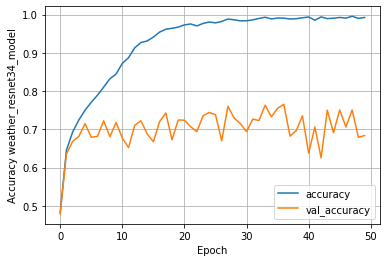

In [ ]:
plt.plot(resnet34_skip_history.history['accuracy'], label='accuracy')
plt.plot(resnet34_skip_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy weather_resnet34_model')
plt.legend()
plt.grid(True)

## 2.2.1. ResNet34 (Skip Connection - ADD)

In [ ]:
class ResNet34Skip():
  def __init__(self):
    pass

  def identity_block(self, inputs, filters):
      x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(inputs)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('relu')(x)
      
      x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
      x = layers.BatchNormalization()(x)
      
      skip_connection = layers.add([inputs, x])     
      x = layers.Activation('relu')(skip_connection)
      
      return x
  
  
  def projection_block(self, inputs, filters, strides=2):
        x = layers.BatchNormalization()(inputs)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=2, use_bias=False)(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', use_bias=False)(x)
        
        
        shortcut = layers.BatchNormalization()(inputs)
        shortcut = layers.Activation('relu')(shortcut)
        shortcut = layers.Conv2D(filters=filters, kernel_size=(1,1), padding='same', 
                             strides=2, use_bias=False)(shortcut)
                             
        return layers.add([shortcut,x])

  def build_model(self, classes, input_shape=(224,224,3)):

      # Input: block 1
      inputs = layers.Input(shape=input_shape)
      x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', use_bias=False)(inputs)
      x = layers.MaxPool2D(pool_size=(3, 3), strides=2)(x)

      # Block 2
      x = self.identity_block(x, 64)
      x = self.identity_block(x, 64)
      x = self.identity_block(x, 64)

      # Block 3
      x = self.projection_block(x, 128)
      x = self.identity_block(x, 128)
      x = self.identity_block(x, 128)
      x = self.identity_block(x, 128)

      # Block 4
      x = self.projection_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)
      x = self.identity_block(x, 256)

      # Output: block 5
      x = layers.GlobalAveragePooling2D()(x)
      outputs = layers.Dense(classes, activation='softmax')(x)

      model = Model(inputs=inputs, outputs=outputs)

      return model

In [ ]:
# add
build_resnet34 = ResNet34Skip()
resnet34_model_skip = build_resnet34.build_model(classes=11)
resnet34_model_skip.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_381 (Conv2D)            (None, 112, 112, 64  9408        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 55, 55, 64)  0           ['conv2d_381[0][0]']             
                                                                                            

In [ ]:
num_epochs=50

resnet34_model_skip.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
                              loss=keras.losses.SparseCategoricalCrossentropy(), 
                              metrics=['accuracy'])

resnet34_skip_history = resnet34_model_skip.fit(train_ds, 
                                    epochs=num_epochs, 
                                    validation_data=val_ds,
                                    verbose=2)

Epoch 1/50
172/172 - 35s - loss: 1.6074 - accuracy: 0.4607 - val_loss: 1.6030 - val_accuracy: 0.4446 - 35s/epoch - 202ms/step
Epoch 2/50
172/172 - 32s - loss: 1.1470 - accuracy: 0.6171 - val_loss: 1.2290 - val_accuracy: 0.5904 - 32s/epoch - 186ms/step
Epoch 3/50
172/172 - 30s - loss: 0.9874 - accuracy: 0.6685 - val_loss: 1.0613 - val_accuracy: 0.6450 - 30s/epoch - 175ms/step
Epoch 4/50
172/172 - 29s - loss: 0.8792 - accuracy: 0.7066 - val_loss: 0.9997 - val_accuracy: 0.6633 - 29s/epoch - 170ms/step
Epoch 5/50
172/172 - 29s - loss: 0.8007 - accuracy: 0.7357 - val_loss: 0.9230 - val_accuracy: 0.6727 - 29s/epoch - 170ms/step
Epoch 6/50
172/172 - 29s - loss: 0.7294 - accuracy: 0.7570 - val_loss: 0.9764 - val_accuracy: 0.6647 - 29s/epoch - 171ms/step
Epoch 7/50
172/172 - 29s - loss: 0.6535 - accuracy: 0.7856 - val_loss: 0.9244 - val_accuracy: 0.6939 - 29s/epoch - 170ms/step
Epoch 8/50
172/172 - 29s - loss: 0.5972 - accuracy: 0.8036 - val_loss: 0.8618 - val_accuracy: 0.7114 - 29s/epoch - 169

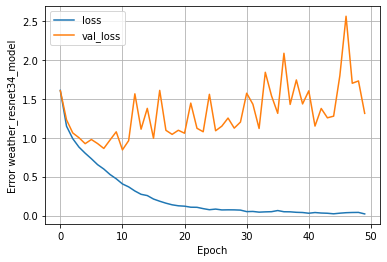

In [ ]:
plt.plot(resnet34_skip_history.history['loss'], label='loss')
plt.plot(resnet34_skip_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error weather_resnet34_model')
plt.legend()
plt.grid(True)

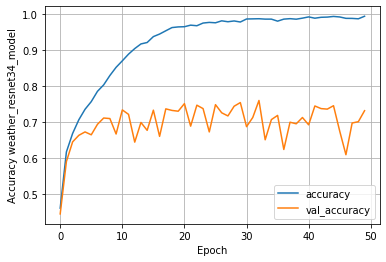

In [ ]:
plt.plot(resnet34_skip_history.history['accuracy'], label='accuracy')
plt.plot(resnet34_skip_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy weather_resnet34_model')
plt.legend()
plt.grid(True)

## 2.3. DenseNet121 (No Skip Connection)

In [ ]:
class DenseNet121NoSkip(): 
  def __init__(self):
    pass

  def conv_block(self, inputs, k=32):
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=4*k, kernel_size=(1, 1), use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=k, kernel_size=(3, 3), padding='same', use_bias=False)(x)

    return x

  def dense_block(self, inputs, num_blocks, k=32):
    for i in range(num_blocks):
      inputs = self.conv_block(inputs, k)

    return inputs

  def transition_layer(self, inputs, fraction=0.5):
    channels = inputs.shape[-1]
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=fraction*channels, kernel_size=(1, 1), use_bias=False)(x)

    return x

  def build_model(self, classes, input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    x = self.dense_block(x, 6)
    x = self.transition_layer(x)

    x = self.dense_block(x, 12)
    x = self.transition_layer(x)
    
    x = self.dense_block(x, 24)
    x = self.transition_layer(x)

    x = self.dense_block(x, 16)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(classes, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
build_densenet121_noskip = DenseNet121NoSkip()
densenet121_noskip_model = build_densenet121_noskip.build_model(classes=11)
densenet121_noskip_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 230, 230, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 114, 114, 64)     0         
 ng2D)                                                           
                                                             

In [ ]:
EPOCHS = 50

densenet121_noskip_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
                                 loss=keras.losses.SparseCategoricalCrossentropy(),
                                 metrics=['accuracy'])

dn121_noskip_history = densenet121_noskip_model.fit(train_ds, 
                                                    epochs=EPOCHS,
                                                    validation_data=val_ds, 
                                                    verbose=2)

Epoch 1/50
172/172 - 154s - loss: 2.4081 - accuracy: 0.1100 - val_loss: 2.3915 - val_accuracy: 0.0962 - 154s/epoch - 894ms/step
Epoch 2/50
172/172 - 133s - loss: 2.3645 - accuracy: 0.1193 - val_loss: 2.3866 - val_accuracy: 0.0962 - 133s/epoch - 776ms/step
Epoch 3/50
172/172 - 134s - loss: 2.3297 - accuracy: 0.1262 - val_loss: 2.3868 - val_accuracy: 0.1567 - 134s/epoch - 777ms/step
Epoch 4/50
172/172 - 135s - loss: 2.2981 - accuracy: 0.1342 - val_loss: 2.3385 - val_accuracy: 0.1625 - 135s/epoch - 786ms/step
Epoch 5/50
172/172 - 134s - loss: 2.2735 - accuracy: 0.1566 - val_loss: 2.3153 - val_accuracy: 0.1698 - 134s/epoch - 777ms/step
Epoch 6/50
172/172 - 134s - loss: 2.2570 - accuracy: 0.1838 - val_loss: 2.2955 - val_accuracy: 0.1735 - 134s/epoch - 776ms/step
Epoch 7/50
172/172 - 135s - loss: 2.2560 - accuracy: 0.1902 - val_loss: 2.2911 - val_accuracy: 0.1800 - 135s/epoch - 782ms/step
Epoch 8/50
172/172 - 136s - loss: 2.2421 - accuracy: 0.1993 - val_loss: 2.2720 - val_accuracy: 0.1822 - 

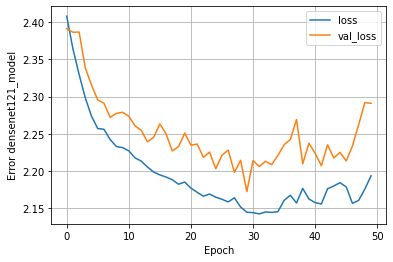

In [ ]:
plt.plot(dn121_noskip_history.history['loss'], label='loss')
plt.plot(dn121_noskip_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error densenet121_model')
plt.legend()
plt.grid(True)

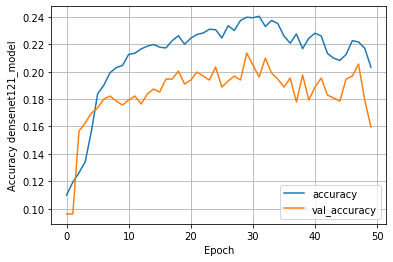

In [ ]:
plt.plot(dn121_noskip_history.history['accuracy'], label='accuracy')
plt.plot(dn121_noskip_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy densenet121_model')
plt.legend()
plt.grid(True)

## 2.4. DenseNet121 (Skip Connection)

In [ ]:
class DenseNet121Skip():
  def __init__(self):
    pass  

  def conv_block(self, inputs, k=32):
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=4*k, kernel_size=(1, 1), use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=k, kernel_size=(3, 3), padding='same', use_bias=False)(x)

    skip_connection = layers.Concatenate(axis=-1)([inputs, x])

    return skip_connection

  def dense_block(self, inputs, num_block, k=32):
    for i in range(num_block):
      inputs = self.conv_block(inputs, k)
    
    return inputs

  def transition_layer(self, inputs, fraction=0.5):
    channels = inputs.shape[-1]
    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=channels*fraction, kernel_size=(1, 1), use_bias=False)(x)
    x = layers.AveragePooling2D(2, strides=2)(x)
    
    return x

  def build_model(self, classes, input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=2, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    x = self.dense_block(x, 6)
    x = self.transition_layer(x)

    x = self.dense_block(x, 12)
    x = self.transition_layer(x)
    
    x = self.dense_block(x, 24)
    x = self.transition_layer(x)

    x = self.dense_block(x, 16)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(classes, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
build_densenet121_skip = DenseNet121Skip()
densenet121_skip_model = build_densenet121_skip.build_model(classes=11)
densenet121_skip_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_14 (ZeroPadding  (None, 230, 230, 3)  0          ['input_8[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_261 (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_14[0][0]']      
                                )                                                           

In [ ]:
EPOCHS = 50

densenet121_skip_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), 
                                 loss=keras.losses.SparseCategoricalCrossentropy(),
                                 metrics=['accuracy'])

dn121_skip_history = densenet121_skip_model.fit(train_ds, 
                                                    epochs=EPOCHS,
                                                    validation_data=val_ds, 
                                                    verbose=2)

Epoch 1/50
172/172 - 87s - loss: 1.6738 - accuracy: 0.4683 - val_loss: 2.0251 - val_accuracy: 0.2551 - 87s/epoch - 507ms/step
Epoch 2/50
172/172 - 67s - loss: 1.2712 - accuracy: 0.5885 - val_loss: 1.2963 - val_accuracy: 0.5561 - 67s/epoch - 391ms/step
Epoch 3/50
172/172 - 67s - loss: 1.1491 - accuracy: 0.6195 - val_loss: 1.1521 - val_accuracy: 0.6093 - 67s/epoch - 390ms/step
Epoch 4/50
172/172 - 67s - loss: 1.0783 - accuracy: 0.6441 - val_loss: 1.0847 - val_accuracy: 0.6239 - 67s/epoch - 389ms/step
Epoch 5/50
172/172 - 67s - loss: 1.0107 - accuracy: 0.6630 - val_loss: 1.0315 - val_accuracy: 0.6472 - 67s/epoch - 391ms/step
Epoch 6/50
172/172 - 67s - loss: 0.9609 - accuracy: 0.6891 - val_loss: 0.9939 - val_accuracy: 0.6713 - 67s/epoch - 389ms/step
Epoch 7/50
172/172 - 67s - loss: 0.9198 - accuracy: 0.6973 - val_loss: 0.9590 - val_accuracy: 0.6829 - 67s/epoch - 391ms/step
Epoch 8/50
172/172 - 67s - loss: 0.8764 - accuracy: 0.7237 - val_loss: 0.8985 - val_accuracy: 0.7092 - 67s/epoch - 389

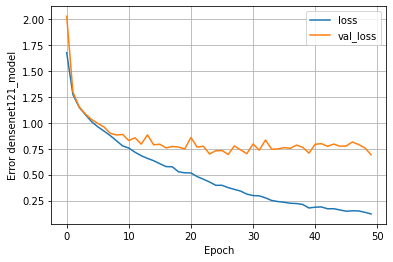

In [ ]:
plt.plot(dn121_skip_history.history['loss'], label='loss')
plt.plot(dn121_skip_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error densenet121_model')
plt.legend()
plt.grid(True)

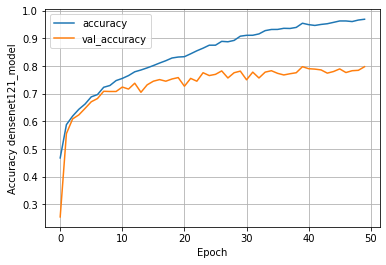

In [ ]:
plt.plot(dn121_skip_history.history['accuracy'], label='accuracy')
plt.plot(dn121_skip_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy densenet121_model')
plt.legend()
plt.grid(True)